Теперь обучим модель случайного леса.
Вообще предполагалось обучать модель SARIMA и спектральную модель, однако они предназначены для нестационарных рядов, а это не наш случай.

Решение взято отсюда: https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost

Оптимизация взята отсюда: https://www.kaggle.com/code/michael127001/xgbregressor-with-optuna-tuning

In [2]:
# Т.к. модуля optuna в Google Colab изначально нет, произведем его установку
%pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 11.5 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
import optuna
from optuna.samplers import TPESampler

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
dailyData = pd.read_csv("drive/MyDrive/Adidas Sales/sales_simplified.csv")
dailyData.drop("Unnamed: 0", axis=1, inplace=True)
dailyData.sort_values(by="index", inplace=True)
dailyData["index"] = pd.to_datetime(dailyData["index"])
weeklyData = pd.DataFrame()
for product in dailyData["Product"].unique():
  buffer = dailyData[dailyData["Product"] == product].copy()
  buffer.sort_values(by="index", inplace=True)
  buffer = buffer.resample("W", kind="timestamp", on="index").mean()
  buffer["Product"] = product
  buffer.reset_index(level="index", inplace=True)
  if len(weeklyData) == 0:
    weeklyData = buffer
  else:
    weeklyData = pd.concat([weeklyData, buffer])

In [6]:
dailyData["dayofweek"] = dailyData["index"].dt.dayofweek
dailyData["quarter"] = dailyData["index"].dt.quarter
dailyData["month"] = dailyData["index"].dt.month
dailyData["year"] = dailyData["index"].dt.year
dailyData["dayofyear"] = dailyData["index"].dt.dayofyear
dailyData["dayofmonth"] = dailyData["index"].dt.day
dailyData["weekofyear"] = dailyData["index"].dt.weekofyear

weeklyData["quarter"] = weeklyData["index"].dt.quarter
weeklyData["month"] = weeklyData["index"].dt.month
weeklyData["year"] = weeklyData["index"].dt.year
weeklyData["weekofyear"] = weeklyData["index"].dt.weekofyear

<ipython-input-6-c83fb64b0a4f>:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  dailyData["weekofyear"] = dailyData["index"].dt.weekofyear
<ipython-input-6-c83fb64b0a4f>:12: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  weeklyData["weekofyear"] = weeklyData["index"].dt.weekofyear


In [7]:
dailyTreshold = "2021-11-01"
weeklyTreshold = "2021-10-24"

In [8]:
dailyData_train, dailyData_test = dailyData.loc[dailyData["index"] <= pd.Timestamp(dailyTreshold)].copy(), dailyData.loc[dailyData["index"] > pd.Timestamp(dailyTreshold)].copy()

weeklyData_train, weeklyData_test = weeklyData.loc[weeklyData["index"] <= pd.Timestamp(weeklyTreshold)].copy(), weeklyData.loc[weeklyData["index"] > pd.Timestamp(weeklyTreshold)].copy()

In [9]:
def getValues(df, label):
  buffer = df[df["Product"] == label].drop(["Product","index"], axis=1)
  X, Y = buffer.drop("Units Sold", axis=1), buffer["Units Sold"]
  return X, Y

In [10]:
def objectiveDaily(trial):
  Xtrain, Ytrain = getValues(dailyData_train, product)
  Xtest, Ytest = getValues(dailyData_test, product)

  param_grid = {
      'max_depth': trial.suggest_int('max_depth', 6, 10), # Extremely prone to overfitting!
      'n_estimators': trial.suggest_int('n_estimators', 400, 4000, 400), # Extremely prone to overfitting!
      'eta': trial.suggest_float('eta', 0.007, 0.013), # Most important parameter.
      'tree_method': trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist']),
      'subsample': trial.suggest_discrete_uniform('subsample', 0.2, 0.9, 0.1),
      'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.2, 0.9, 0.1),
      'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel', 0.2, 0.9, 0.1),
      'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-4, 1e4), # I've had trouble with LB score until tuning this.
      'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e4), # L2 regularization
      'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e4), # L1 regularization
      'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),
  } 
  
  reg = xgb.XGBModel(
      # These parameters should help with trial speed.
      objective='reg:squarederror',
      **param_grid
  )
  
  reg.fit(Xtrain, Ytrain,
          eval_set=[(Xtrain, Ytrain), (Xtest, Ytest)], eval_metric='rmse',
          verbose=False)

  # Returns the best RMSE for the trial.
  # Readers may want to try returning a cross validation score here.
  return mean_squared_error(Ytest, reg.predict(Xtest), squared=False)

In [10]:
dailyRegressorsParams = {}
# train_time = 3600
train_time = 60 * 10
for product in dailyData["Product"].unique():
  study = optuna.create_study(direction='minimize', sampler=TPESampler(), study_name='XGBRegressor')
  study.optimize(objectiveDaily, timeout=train_time, show_progress_bar=True)
  trial = study.best_trial
  dailyRegressorsParams[product] = trial.params

Output hidden; open in https://colab.research.google.com to view.

In [11]:
pd.DataFrame(dailyRegressorsParams, index=dailyRegressorsParams[product].keys())

,Men's Street Footwear,Women's Athletic Footwear,Men's Athletic Footwear,Men's Apparel,Women's Apparel,Women's Street Footwear
max_depth,8,7,6,8,7,7
n_estimators,1600,3600,1200,2800,1200,2000
eta,0.009038,0.011008,0.010754,0.009827,0.008201,0.008599
tree_method,hist,exact,exact,approx,exact,exact
subsample,0.3,0.9,0.2,0.6,0.8,0.6
colsample_bytree,0.9,0.2,0.2,0.4,0.2,0.9
colsample_bylevel,0.6,0.4,0.8,0.5,0.9,0.2
min_child_weight,41.697269,63.581612,8.029296,80.106688,0.001248,57.791876
reg_lambda,0.004139,0.000394,0.596517,0.216404,121.777043,1.773284
reg_alpha,90.159006,54.327842,1.661239,1.859239,0.000731,0.077439


In [11]:
dailyRegressors = {}
for product in dailyRegressorsParams.keys():
  Xtrain, Ytrain = getValues(dailyData_train, product)
  Xtest, Ytest = getValues(dailyData_test, product)
  dailyRegressor = xgb.XGBRegressor(early_stopping_rounds=50, eval_metric="rmse", **dailyRegressorsParams[product])
  dailyRegressor.fit(Xtrain, Ytrain,
                    eval_set=[(Xtrain, Ytrain), (Xtest, Ytest)],
                    verbose=False)
  dailyRegressors[product] = dailyRegressor

NameError: ignored

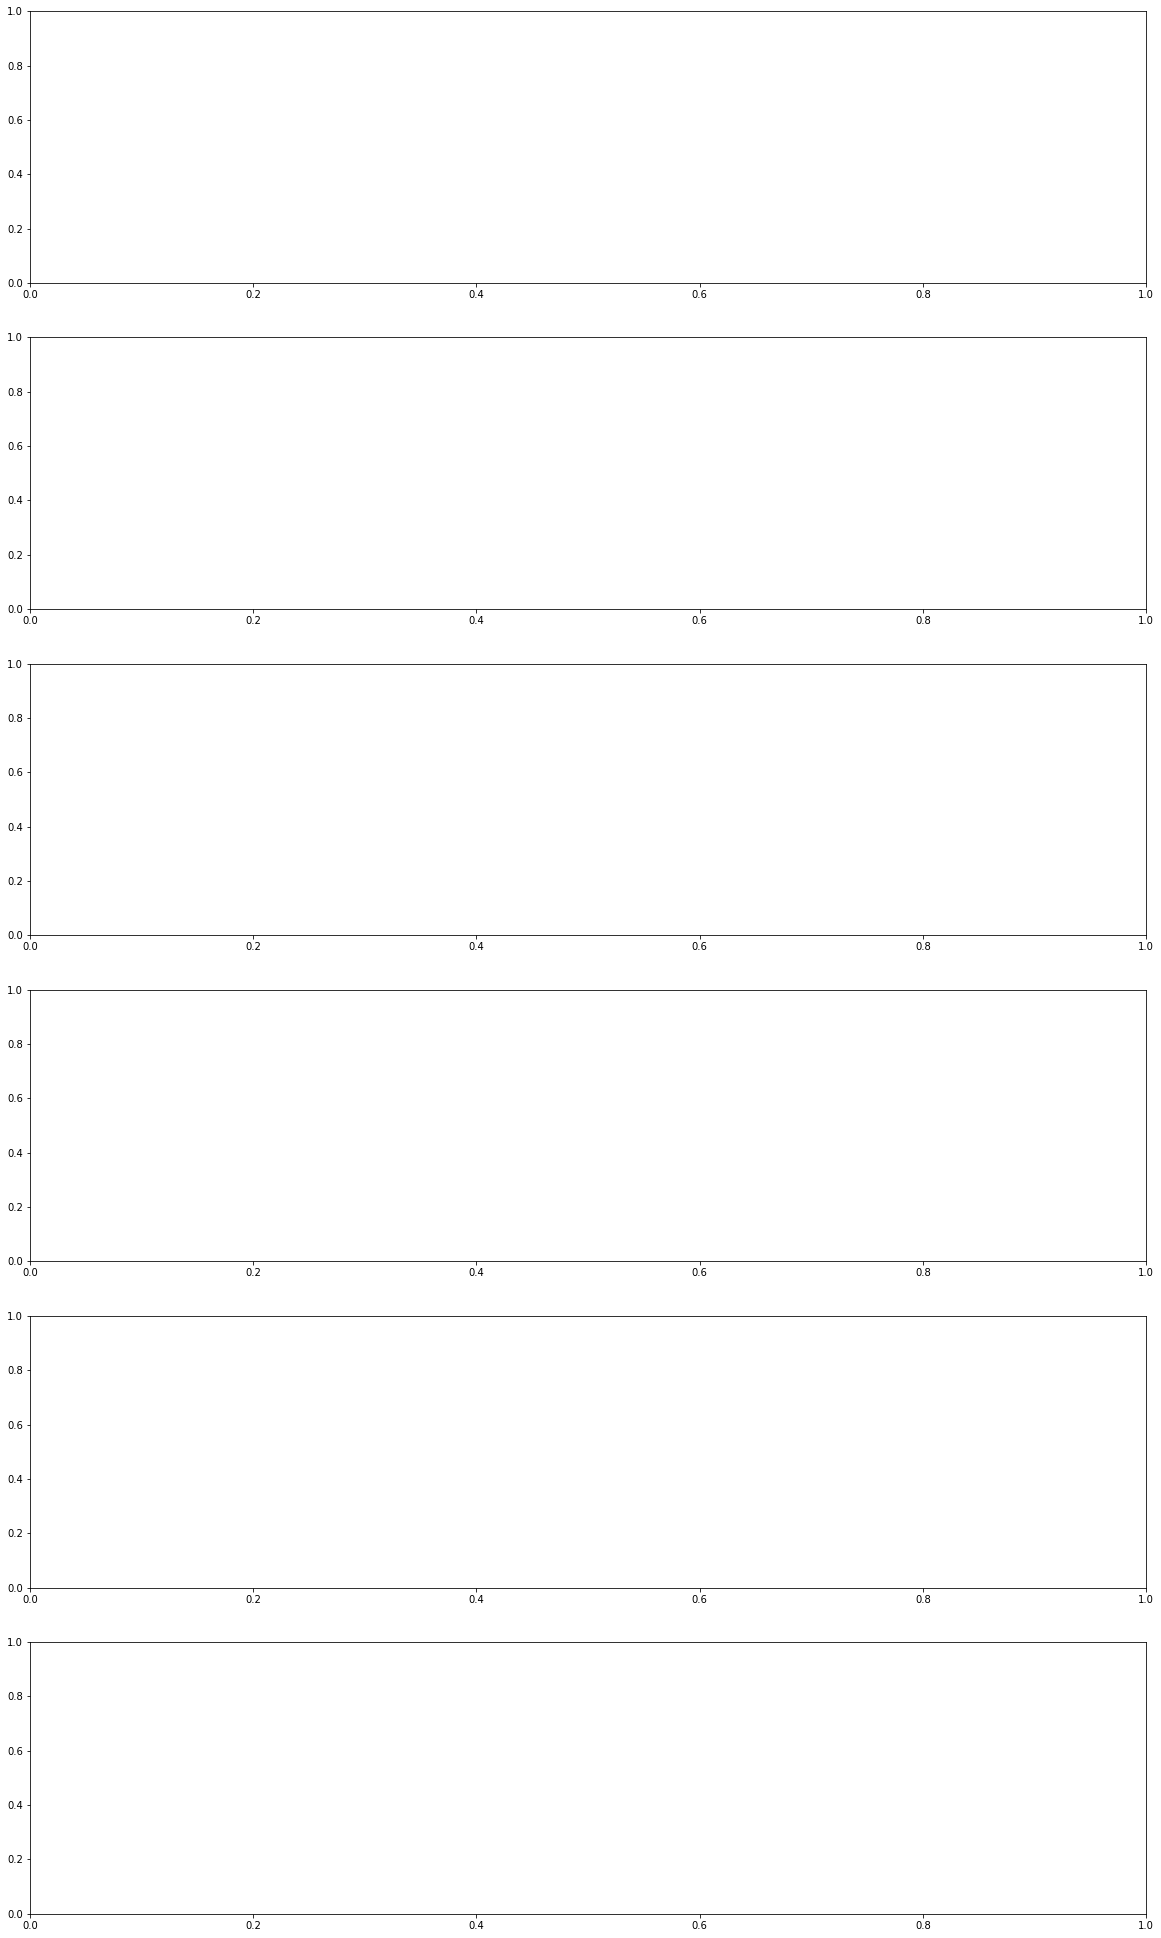

In [12]:
# Важность параметров
fig, axs = plt.subplots(6, 1, figsize=(20, 35))
for i, product in enumerate(dailyRegressors.keys()):
  _ = plot_importance(dailyRegressors[product], ax=axs[i], height=0.9)
  axs[i].set_title(product)

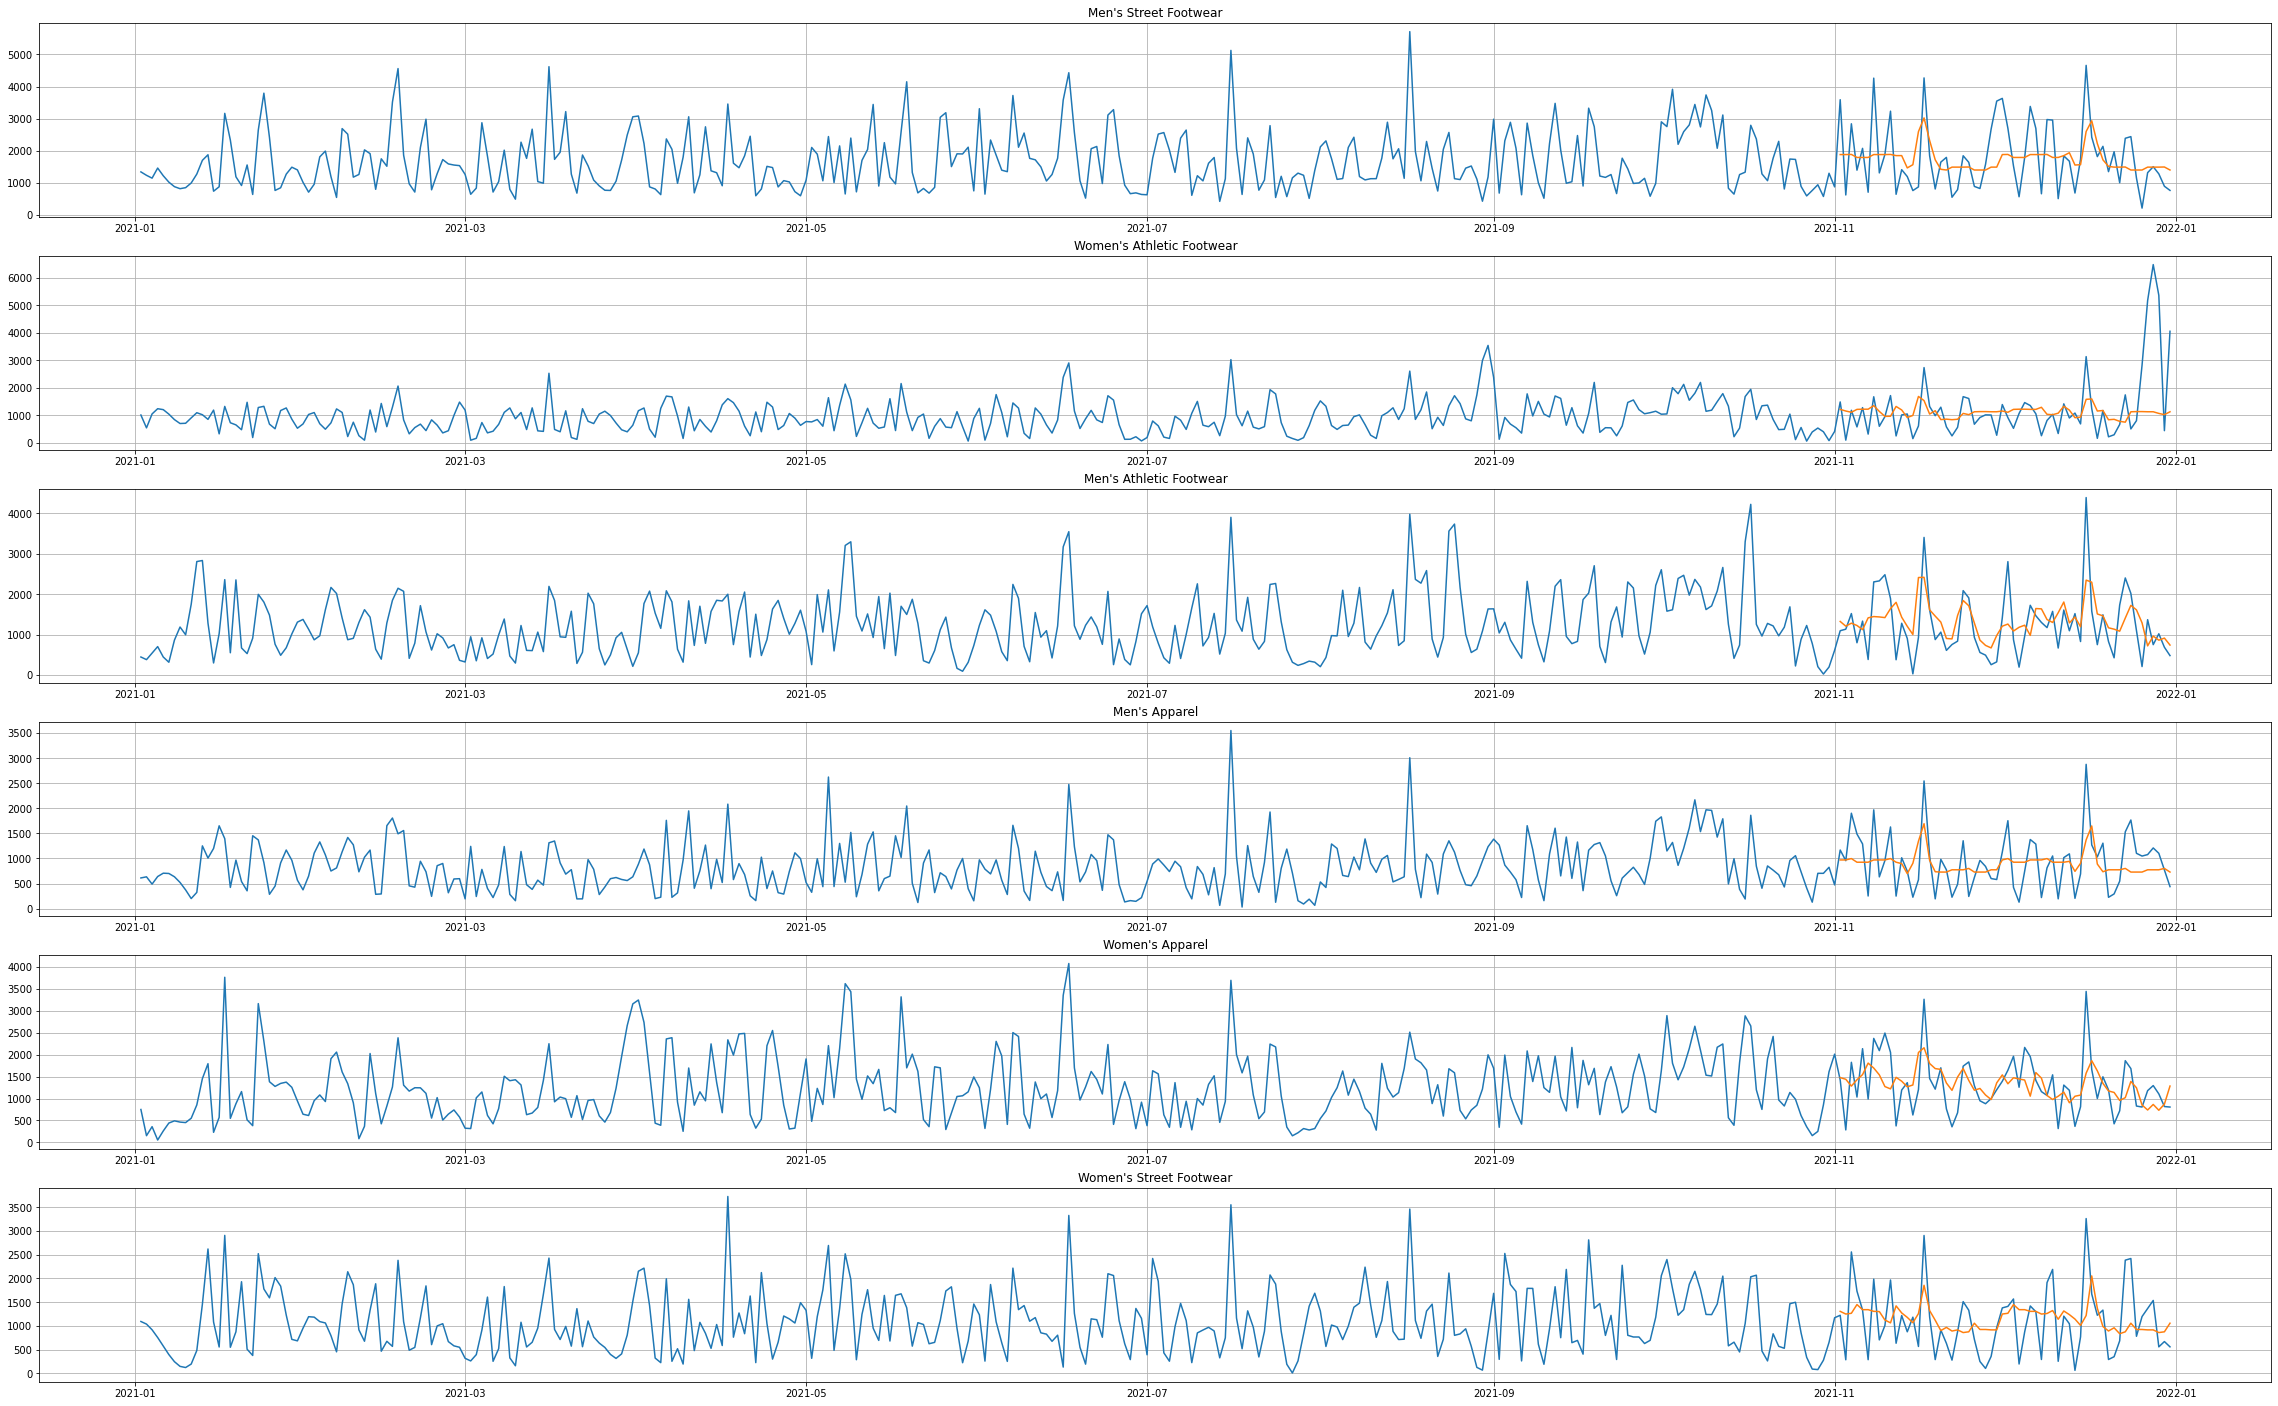

In [14]:
fig, axs = plt.subplots(6, 1, figsize=(40, 25))
for i, product in enumerate(dailyData_train["Product"].unique()):
  test_buffer = dailyData_test[dailyData_test["Product"] == product].copy()
  train_buffer = dailyData_train[dailyData_train["Product"] == product].copy()

  test_buffer["Predictions"] = dailyRegressors[product].predict(test_buffer.drop(["Product", "index", "Units Sold"], axis=1))

  bufferAll = pd.concat([train_buffer, test_buffer])

  axs[i].plot(bufferAll["index"], bufferAll["Units Sold"], label="Raw")
  axs[i].plot(bufferAll["index"], bufferAll["Predictions"], label="Predicted")

  axs[i].set_title(product)
  axs[i].grid()

In [13]:
for i, product in enumerate(dailyData_train["Product"].unique()):
  test_buffer = dailyData_test[dailyData_test["Product"] == product].copy()
  error = mean_squared_error(y_true=test_buffer['Units Sold'], y_pred=dailyRegressors[product].predict(test_buffer.drop(["Product", "index", "Units Sold"], axis=1)), squared=False)
  print("Product: {} Error: {}".format(product, error))

KeyError: ignored

In [14]:
def objectiveWeekly(trial):
  Xtrain, Ytrain = getValues(weeklyData_train, product)
  Xtest, Ytest = getValues(weeklyData_test, product)

  param_grid = {
      'max_depth': trial.suggest_int('max_depth', 6, 10), # Extremely prone to overfitting!
      'n_estimators': trial.suggest_int('n_estimators', 400, 4000, 400), # Extremely prone to overfitting!
      'eta': trial.suggest_float('eta', 0.007, 0.013), # Most important parameter.
      'tree_method': trial.suggest_categorical('tree_method', ['exact', 'approx', 'hist']),
      'subsample': trial.suggest_discrete_uniform('subsample', 0.2, 0.9, 0.1),
      'colsample_bytree': trial.suggest_discrete_uniform('colsample_bytree', 0.2, 0.9, 0.1),
      'colsample_bylevel': trial.suggest_discrete_uniform('colsample_bylevel', 0.2, 0.9, 0.1),
      'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-4, 1e4), # I've had trouble with LB score until tuning this.
      'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-4, 1e4), # L2 regularization
      'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-4, 1e4), # L1 regularization
      'gamma': trial.suggest_loguniform('gamma', 1e-4, 1e4),
  } 
  
  reg = xgb.XGBModel(
      # These parameters should help with trial speed.
      objective='reg:squarederror',
      **param_grid
  )
  
  reg.fit(Xtrain, Ytrain,
          eval_set=[(Xtrain, Ytrain), (Xtest, Ytest)], eval_metric='rmse',
          verbose=False)

  # Returns the best RMSE for the trial.
  # Readers may want to try returning a cross validation score here.
  return mean_squared_error(Ytest, reg.predict(Xtest), squared=False)

In [15]:
weeklyRegressorsParams = {}
# train_time = 3600
train_time = 60 * 10
for product in dailyData["Product"].unique():
  study = optuna.create_study(direction='minimize', sampler=TPESampler(), study_name='XGBRegressor')
  study.optimize(objectiveWeekly, timeout=train_time, show_progress_bar=True)
  trial = study.best_trial
  weeklyRegressorsParams[product] = trial.params

Output hidden; open in https://colab.research.google.com to view.

In [16]:
pd.DataFrame(weeklyRegressorsParams, index=weeklyRegressorsParams[product].keys())

,Men's Street Footwear,Women's Athletic Footwear,Men's Athletic Footwear,Men's Apparel,Women's Apparel,Women's Street Footwear
max_depth,8,10,6,9,9,8
n_estimators,2400,2400,2400,1200,2000,1600
eta,0.009038,0.008264,0.009882,0.01002,0.007202,0.010828
tree_method,exact,hist,hist,hist,hist,exact
subsample,0.8,0.2,0.9,0.7,0.3,0.6
colsample_bytree,0.4,0.5,0.5,0.9,0.6,0.4
colsample_bylevel,0.4,0.9,0.9,0.2,0.8,0.8
min_child_weight,0.077572,8.686537,0.005039,6.276647,0.018863,0.011762
reg_lambda,16.601473,1.470198,0.522567,467.467241,459.217461,8.736874
reg_alpha,0.000219,3.161858,1943.858588,0.276574,0.295442,33.643736


In [24]:
weeklyRegressors = {}
for product in weeklyRegressorsParams.keys():
  Xtrain, Ytrain = getValues(weeklyData_train, product)
  Xtest, Ytest = getValues(weeklyData_test, product)
  weeklyRegressor = xgb.XGBRegressor(early_stopping_rounds=50, eval_metric="rmse", **weeklyRegressorsParams[product])
  weeklyRegressor.fit(Xtrain, Ytrain,
                    eval_set=[(Xtrain, Ytrain), (Xtest, Ytest)],
                    verbose=False)
  weeklyRegressors[product] = weeklyRegressor

[09:44:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:44:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:44:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:44:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:44:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:44:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [25]:
weeklyRegressors

{"Men's Street Footwear": XGBRegressor(colsample_bylevel=0.4, colsample_bytree=0.4,
              early_stopping_rounds=50, eta=0.009038357371549113,
              eval_metric='rmse', gamma=0.00042351500786509547, max_depth=8,
              min_child_weight=0.07757248935580943, n_estimators=2400,
              reg_alpha=0.00021896075016459053, reg_lambda=16.601472641815768,
              subsample=0.8, tree_method='exact'),
 "Women's Athletic Footwear": XGBRegressor(colsample_bylevel=0.9, colsample_bytree=0.5,
              early_stopping_rounds=50, eta=0.008263891459599833,
              eval_metric='rmse', gamma=0.016740533206387253, max_depth=10,
              min_child_weight=8.686537289903011, n_estimators=2400,
              reg_alpha=3.1618580349619494, reg_lambda=1.4701979643534102,
              subsample=0.2, tree_method='hist'),
 "Men's Athletic Footwear": XGBRegressor(colsample_bylevel=0.9, colsample_bytree=0.5,
              early_stopping_rounds=50, eta=0.0098822992480586

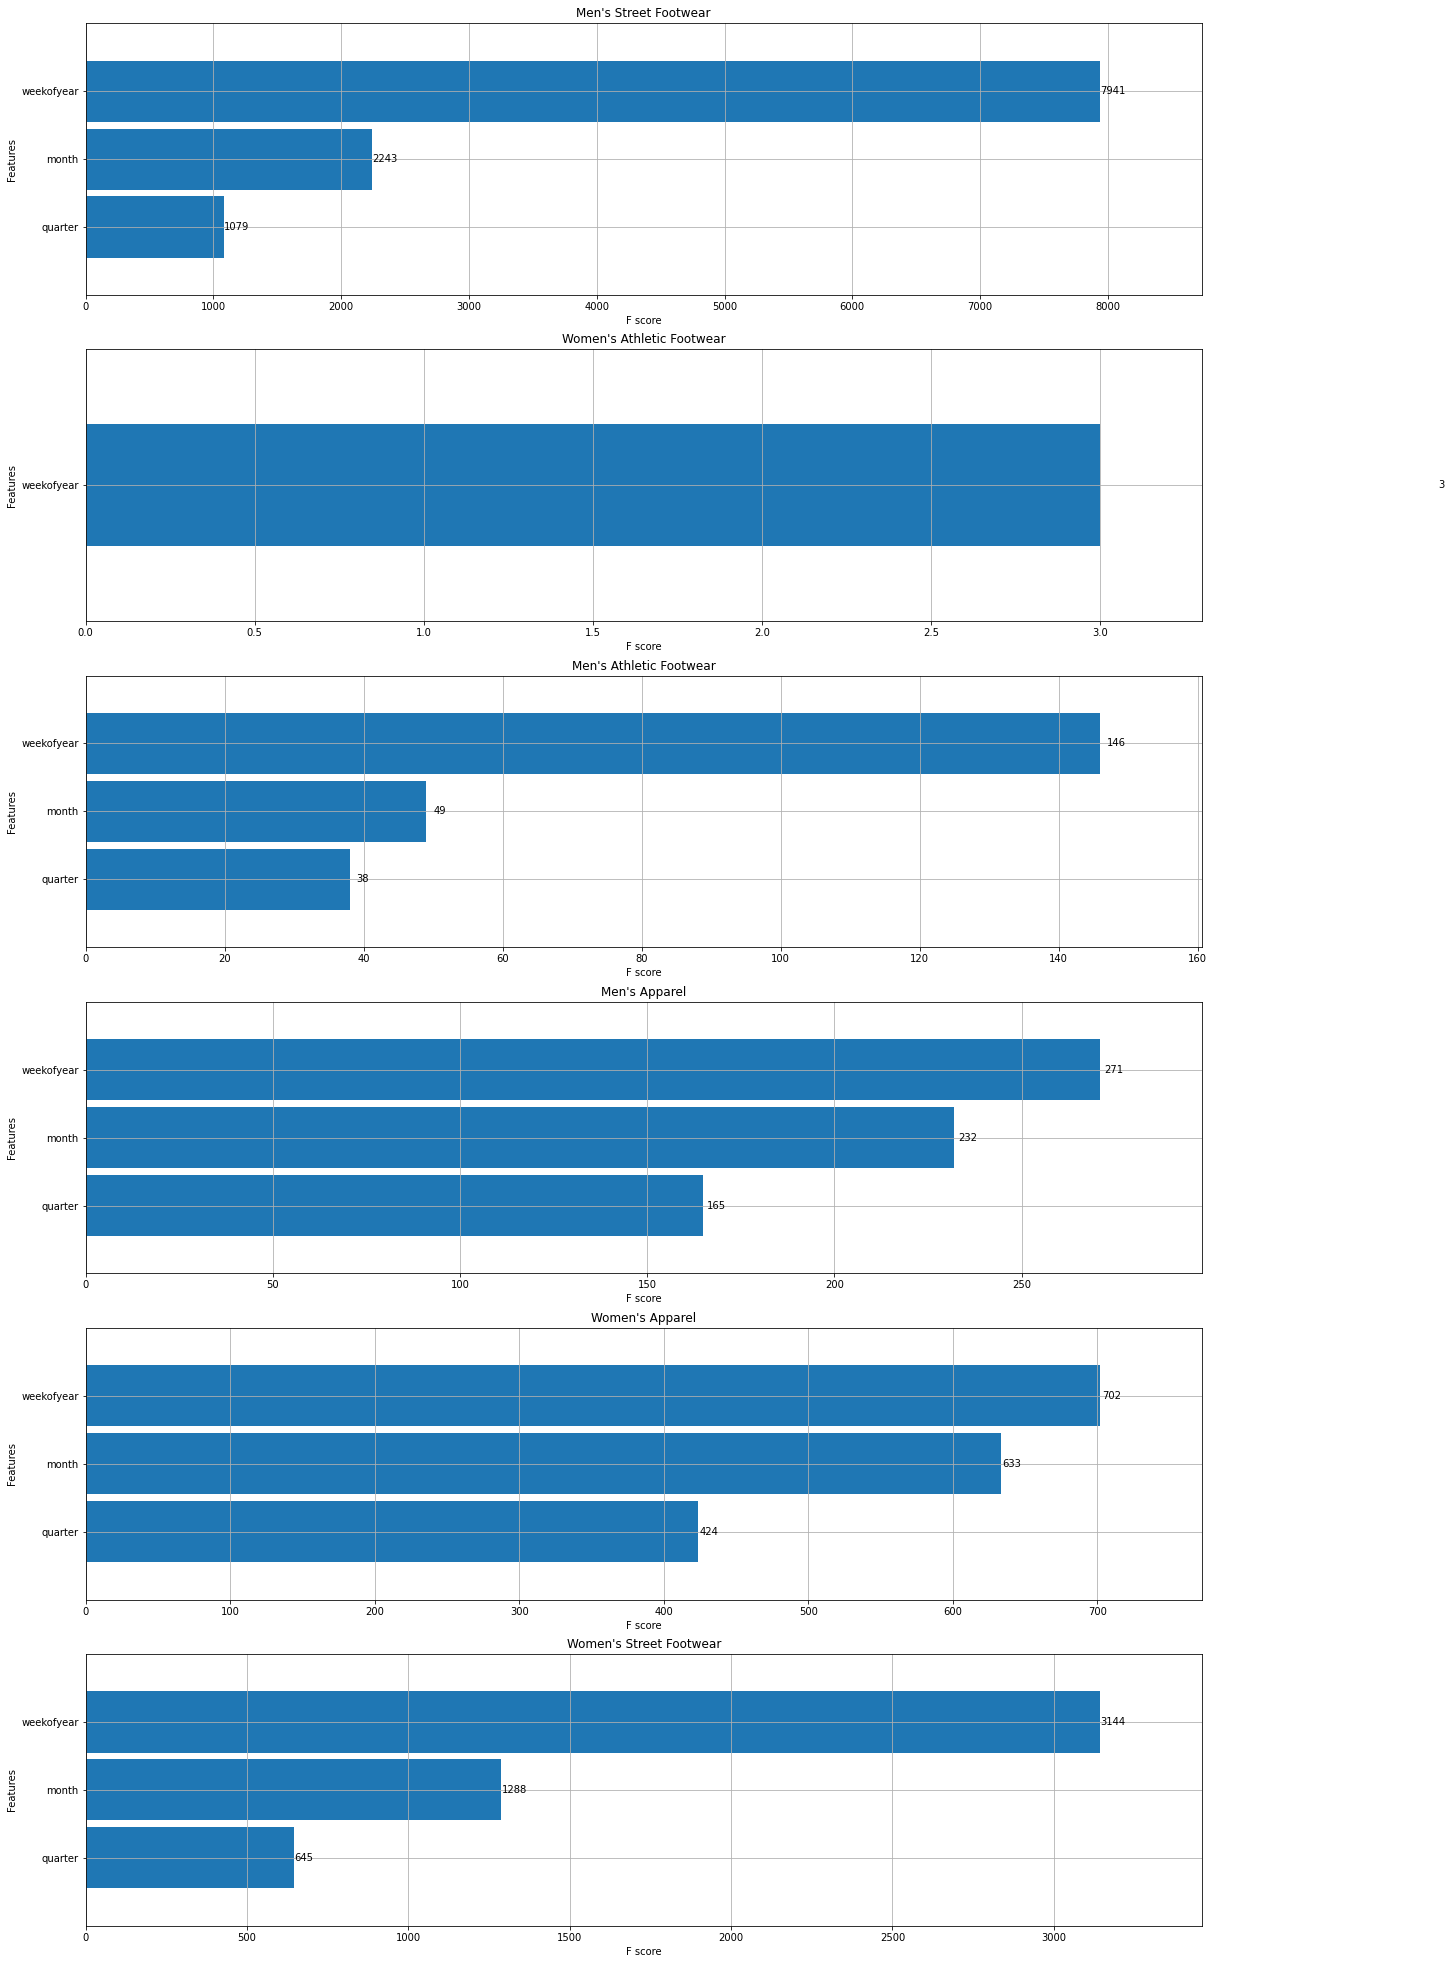

In [26]:
# Важность параметров
fig, axs = plt.subplots(6, 1, figsize=(20, 35))
for i, product in enumerate(weeklyRegressors.keys()):
  _ = plot_importance(weeklyRegressors[product], ax=axs[i], height=0.9)
  axs[i].set_title(product)

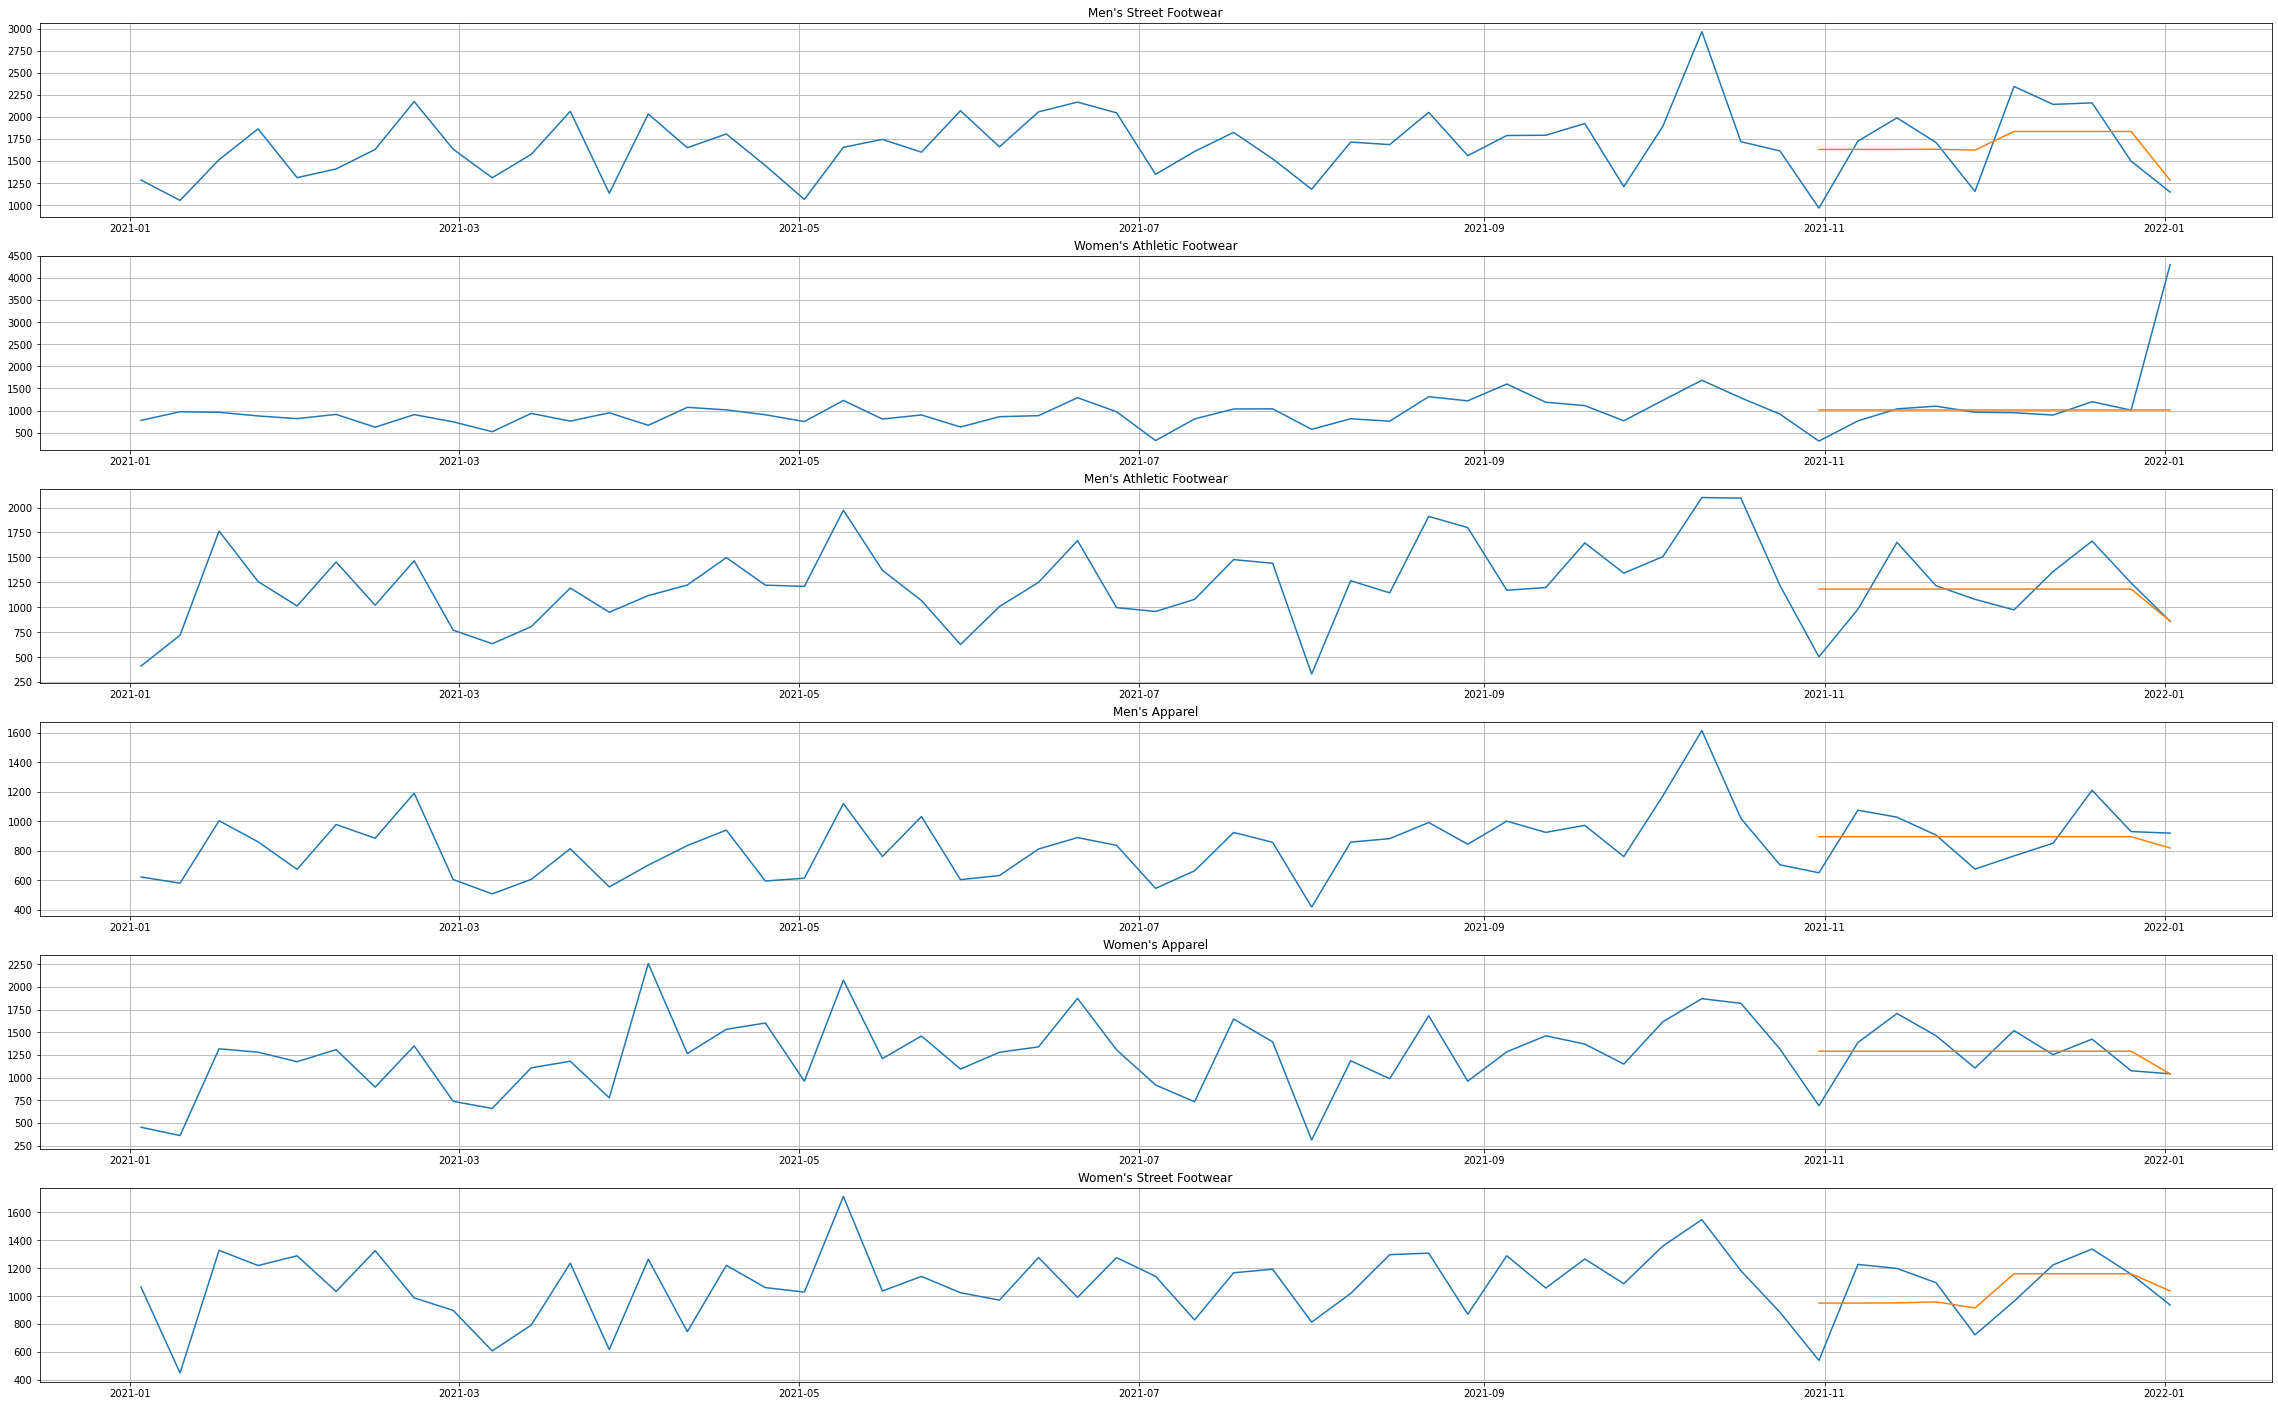

In [27]:
fig, axs = plt.subplots(6, 1, figsize=(40, 25))
for i, product in enumerate(weeklyData_train["Product"].unique()):
  test_buffer = weeklyData_test[weeklyData_test["Product"] == product].copy()
  train_buffer = weeklyData_train[weeklyData_train["Product"] == product].copy()

  test_buffer["Predictions"] = weeklyRegressors[product].predict(test_buffer.drop(["Product", "index", "Units Sold"], axis=1))

  bufferAll = pd.concat([train_buffer, test_buffer])

  axs[i].plot(bufferAll["index"], bufferAll["Units Sold"], label="Raw")
  axs[i].plot(bufferAll["index"], bufferAll["Predictions"], label="Predicted")

  axs[i].set_title(product)
  axs[i].grid()

In [28]:
for i, product in enumerate(weeklyData_train["Product"].unique()):
  test_buffer = weeklyData_test[weeklyData_test["Product"] == product].copy()
  error = mean_squared_error(y_true=test_buffer['Units Sold'], y_pred=weeklyRegressors[product].predict(test_buffer.drop(["Product", "index", "Units Sold"], axis=1)))
  print("Product: {} Error: {}".format(product, error))

Product: Men's Street Footwear Error: 139450.63988572476
Product: Women's Athletic Footwear Error: 1150971.1318731313
Product: Men's Athletic Footwear Error: 104309.22008318047
Product: Men's Apparel Error: 28702.78997865294
Product: Women's Apparel Error: 72571.0715192215
Product: Women's Street Footwear Error: 44696.63717823851


Бейзлайн по случайному лесу частично закончен.

Матвей, тебе задание.
Нужно так же обучить XGBoost-модели, но в sales_simplified.csv надо добавить колонки из оригинального датасета, и посмотреть, на сколько возрастет качество модели.

Задача довольно творческая, т.к. многие из добавленных параметров категориальные, т.е. их сперва надо преобразовать в какой-либо численный вид, например параметр "Sales Method" можно представить в виде последовательноси из 0 и 1.

Еще есть вариант не преобразовывать их, а прописать в XGBModel и в XGBRegressor опцию: enable_categorical=True. Она позволяет оперировать такими переменными, см. документацию.

Попробуй оба варианта для чистоты эксперимента.